In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [36]:
d, Nobs = 2_000, 2_000
X = sprandn(d, Nobs, 1e-1)
X[1,:] = ones(Nobs)
nz = 50
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(5,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(5,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [37]:
σ02 = 1
prior = HS_prior(d, σ02);
# prior = gaussian_prior_nh(d, σ02);

#### Define model:

In [38]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
# root = find_root(my_model, rand(d));

#### Define minibatch sampler:

In [39]:
# Sub-Sampling without control variate and with weights
mb_size = 20
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)

@showprogress for i in 2:d 
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


#### Define output scheduler:

In [40]:
bb_copy = linear_bound(my_model.ll, my_model.pr, gs_list);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [41]:
A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(10^7)
outp = outputscheduler(opf,opt)
bb = deepcopy(bb_copy)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [42]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e2)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [43]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10 percent attempts in 8.06 min; zz bounces = 345612, hyp bounces = 80, total time = 0.811 
20 percent attempts in 16.71 min; zz bounces = 732521, hyp bounces = 117, total time = 1.148 
30 percent attempts in 25.64 min; zz bounces = 1086141, hyp bounces = 135, total time = 1.324 
40 percent attempts in 34.86 min; zz bounces = 1451828, hyp bounces = 154, total time = 1.484 
50 percent attempts in 45.03 min; zz bounces = 1859406, hyp bounces = 177, total time = 1.744 
60 percent attempts in 54.17 min; zz bounces = 2208803, hyp bounces = 187, total time = 1.893 
70 percent attempts in 64.21 min; zz bounces = 2506926, hyp bounces = 187, total time = 1.911 
80 percent attempts in 74.28 min; zz bounces = 2836639, hyp bounces = 195, total time = 2.008 
90 percent attempts in 85.47 min; zz bounces = 3228729, hyp bounces = 209, total time = 2.168 
100 percent attempts in 96.36 min; zz bounces = 3596106, hyp bounces = 222, total time = 2.271 


In [44]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i \n", zz_bounces, hyp_bounces)
@printf("%.1f percent of ZZ bounces accepted \n", 100*sum(mstate.n_bounces)/(outp.opt.max_attempts-hyp_bounces))
@printf("Total time: %.2f", maximum(outp.opf.bt_skeleton))

ZZ total bounces: 3596106, hyper bounces: 223 
36.0 percent of ZZ bounces accepted 
Total time: 2.27

#### Confidence interval:

In [45]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:00

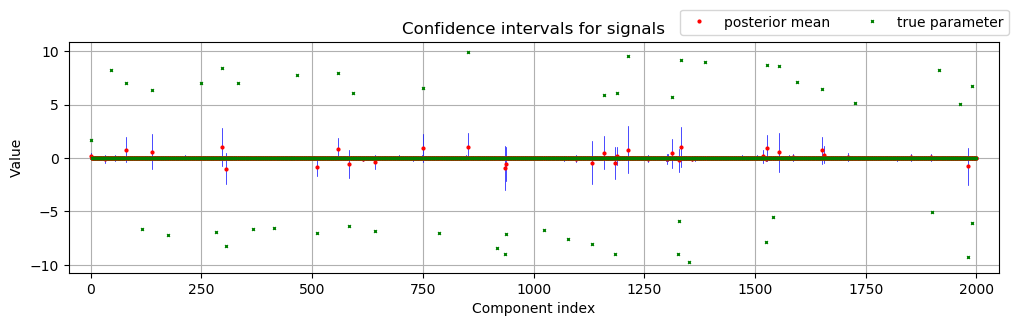

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


PyObject <matplotlib.legend.Legend object at 0x7fbae6a3c0f0>

In [46]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=2, label="true parameter")
grid(true)
xlim(-50,d+50)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))